In [98]:
import scipy.io
import numpy as np
from numpy.fft import fft, rfft, rfftfreq, fftfreq
import pandas as pd
from os import listdir, path
from os.path import isfile, join
import datetime
import dateutil.parser as parser
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, hanning, welch, get_window, periodogram
import cProfile
import time

### Function changing the MATLAB timestamp format to YYY-MM-dd HH:mm:ss
MATLAB provides a default timestamp format ```2020-JAN-01 00:00:00```.

My approach here is to convert it to the more useful datetime format ```YYYY:MM:dd HH:mm:ss```, in order to use the DateTimeIndex in *pandas.DataFrame* objects later.


In [2]:
def change_date_format(timestamp):
    return parser.parse(timestamp)

### Generator extracting all data from MATLAB files
Sort the list of filenames lexicographically.
> Google Collabs changes the order for some reason (probably because of different default data storing order order on Google Drive).
> In PyCharm it works without any sorting, however this step does not take much time and does not impact the performance much.

In [3]:
def extract_all_data_from_mat(mat_path, n_signals=999):

    # Use sorted list of filenames
    only_files = sorted([file for file in listdir(mat_path) if isfile(join(mat_path, file))])
    assert len(only_files) == n_signals, 'Number of files must be equal to 999!'

    for file_name in only_files:
            try:

                mat_file = path.join(mat_path, file_name)
                mat = scipy.io.loadmat(mat_file)

                # numpy array containing data
                extracted_data = mat['data'][0]

                # timestamp
                extracted_timestamp = mat['timestamp_str'][0]

            except TypeError:
                print(f'{file_name} is corrupted.')
            else:
                # datetime_object, np.ndarray
                yield change_date_format(extracted_timestamp), extracted_data

In [4]:
fs = 25000  # sampling frequency 25kHz
T = 10  # time of signal 10s
n = 999 # number of signals
N = fs * T  # number of samples
dt = 1 / fs

Single signal is in the following format:
```
signals = np.array([
            single_signal=[
                  datetime, data
                  ],
                  ...
          ])
```

In [5]:
mat_files_path = r'C:\Users\szczy\Bachelor\MODE 7 - Miscellaneous\Data mat'

# Dictionary containing data extracted from MATLAB files
all_data = {datetime: data for datetime, data in extract_all_data_from_mat(mat_files_path, n)}

### Create DataFrame
* DataFrame will be grouped by timestamp.
* DataFrame column names will correspond to each single piece of data.

In [6]:
id = [f'{i}' for i in range(N)]

At first create the DataFrame from dictionary, with datetime as columns by default.
Then transpose the DataFrame, in order to have datetime as index column.
Formatting dataset in such a manner will speed up the whole process.

> Remember to format the index to DateTimeIndex.

#### Default DataFrame (nodes as index column)

In [7]:
mode7_df = pd.DataFrame(data=all_data,
                        index=id)

mode7_df.head()

,2020-10-16 10:51:26,2020-10-17 10:51:26,2020-10-18 10:51:26,2020-10-19 10:51:26,2020-10-20 10:51:26,2020-10-21 10:51:26,2020-10-22 10:51:26,2020-10-23 10:51:26,2020-10-24 10:51:26,2020-10-25 10:51:26,...,2023-07-02 10:51:26,2023-07-03 10:51:26,2023-07-04 10:51:26,2023-07-05 10:51:26,2023-07-06 10:51:26,2023-07-07 10:51:26,2023-07-08 10:51:26,2023-07-09 10:51:26,2023-07-10 10:51:26,2024-11-23 10:51:26
0,0.040139,-0.019137,0.246735,-0.992886,-0.191269,-1.192573,0.065359,0.195485,-0.998345,-0.970555,...,-1.350811,1.523109,-0.179998,-1.426347,-0.155563,-1.315735,4.418102,1.163728,-1.250167,3.169873
1,-0.013953,-0.114124,0.420629,-0.987975,-0.237793,-1.658476,-0.395250,1.342441,-0.480948,-0.022567,...,-3.003104,1.913759,1.570426,2.704646,-2.664688,1.002145,1.585775,-1.238528,-0.625369,3.139401
2,-0.374629,-0.823414,0.233720,-0.690192,-0.151192,-1.365626,-0.709879,1.728005,0.751725,0.143145,...,0.875428,2.715714,-1.714959,2.184236,-1.378298,-1.644101,-1.138982,3.533414,1.644274,-2.094080
3,-0.430754,-1.115094,-0.252937,0.136254,-0.875230,-0.152288,-1.081007,1.143398,1.632306,0.644977,...,2.258582,3.400384,-0.256517,-0.960197,3.999186,-1.281836,0.747549,2.574273,0.075851,1.363682
4,-1.279705,-0.905094,-0.733160,0.694803,-1.079586,0.886533,-0.939096,0.625139,1.238999,1.207549,...,2.697467,0.974775,1.024606,-0.081627,2.878134,3.491390,2.188840,-3.642731,-1.972802,2.552475


#### Transposed DataFrame (datetime as index column)

In [8]:
mode7_dfT = mode7_df.transpose() # transpose the DataFrame
mode7_dfT.head()


,0,1,2,3,4,5,6,7,8,9,...,249990,249991,249992,249993,249994,249995,249996,249997,249998,249999
2020-10-16 10:51:26,0.040139,-0.013953,-0.374629,-0.430754,-1.279705,-1.696699,-1.294250,-0.727258,0.020795,0.940798,...,-0.300496,-0.790838,-0.540505,0.372666,0.544504,0.150038,-0.004734,0.527103,0.714635,-0.207416
2020-10-17 10:51:26,-0.019137,-0.114124,-0.823414,-1.115094,-0.905094,-0.189646,1.294521,2.009437,1.552688,0.444696,...,-0.709162,-0.367087,-0.129230,-0.114574,-0.117939,-0.721022,-0.391528,-0.339336,-0.061173,0.388111
2020-10-18 10:51:26,0.246735,0.420629,0.233720,-0.252937,-0.733160,-0.072274,-0.335648,-0.852295,-0.853636,-1.440288,...,1.005050,1.100118,1.213951,0.615521,-0.368691,0.290896,0.967391,0.101787,-0.485911,-0.355975
2020-10-19 10:51:26,-0.992886,-0.987975,-0.690192,0.136254,0.694803,0.226265,-0.867183,-2.149532,-1.676542,-0.984665,...,0.488530,-0.054778,-0.030117,-0.234258,0.352841,0.022201,-0.945641,-0.164169,-0.237284,0.024183
2020-10-20 10:51:26,-0.191269,-0.237793,-0.151192,-0.875230,-1.079586,-1.045724,-0.927799,0.251050,1.346321,2.077986,...,-0.827944,-0.228974,-0.085456,-0.920004,-0.782188,0.236261,0.709100,0.447058,0.125537,-0.044236


### Export the CSV containing data for all signals

In [9]:
# mode7_dfT.to_csv('D:\Praca Inżynierska\csv_files\mode7_transposed_full.csv')

### Conclusion:
> It is better to actually gather the data directly from .mat files, instead of creating the CSV neither in MATLAB nor using Python scripts.

The reason for that is the total amount of data. We have 999 datetime objects as index, however in case of t=10s and fs=25kHz, the total number of samples is 250,000. The CSV weights ~4.9Gb and I cannot open it in any spreadsheet.

There are 2 solutions for that issue:
* Work temporarily on the DataFrame containing all data from extracted .mat files
* Use averaging


### Calculate RMS for each signal

In [10]:
def rms(data_arr):
    return np.sqrt(np.mean(np.power(data_arr, 2)))

def rms_for_every_signal(data_dict):
    return {datetime: rms(data) for datetime, data in data_dict.items()}

In [11]:
mode7_rms = rms_for_every_signal(all_data)

### Create a DataFrame containing RMS for each signal.

In [12]:
mode7_rms_df = pd.DataFrame(data=mode7_rms.values(), index=mode7_rms.keys(), columns=['RMS'])
mode7_rms_df.head()

,RMS
2020-10-16 10:51:26,0.398396
2020-10-17 10:51:26,0.396055
2020-10-18 10:51:26,0.398734
2020-10-19 10:51:26,0.425583
2020-10-20 10:51:26,0.398431


Export RMS .csv

In [13]:
# mode7_rms_df.to_csv('D:\Praca Inżynierska\csv_files\MODE7_RMS.csv')

# Frequency Analysis
Digital signals can be analised in time and frequency domain. Algorithms based on the time domain operate directly on samples from digital signal. **Frequency analysis** of the signal is about transforming the signal from time to frequency domain. **Spectrum** of the signal is a visual representation of the frequency, usually the **Frequency analysis** is alternatively called **Spectrum analysis**.

*Jean-Baptiste Joseph Fourier* discovered, that any periodic signal can be represented as **Fourier Series**, that is the sum of trigonometric signals (cosines and sines) characterized by different amplitudes and frequencies.

The operation of transformation the signal from time to frequency domain is called the **Fourier Transform**. In case of discrete signals (digital), we refer to the **Discrete Fourier Transform**.

The practical use of **Fourier Transform** applies to the **Fast Fourier Transform* algorithm.

> *numpy* library contains the ```numpy.fft``` module, in which the ```fft()``` method is implemented

### Magnitude Spectrum
Based on n samples from the digital signal, we can calculate n values for the complex spectrum. Since the spectrum of the signal is complex, we usually analyse the module of the spectrum. The most commonly analysed is the **Magnitude Spectrum**.

> **Magnitude Spectrum** is obtained with the use of ```numpy.abs()``` method, taking the FFT of the time-domain signal as an argument.

### Spectral averaging (Uśrednienie widma) for Magnitude Spectrum
* k = the level of averaging

For ```t=10s``` signal with sampling frequency ```fs=25kHz``` we obtain total number of samples ```N=250,000``` *(fs * t)*.

We segment the signal into ```k=100``` equal ```dt=0.1s``` (t/k) data chunks, containing ```chunk_n_samples=2,500``` *(N / k)* samples.

On each part of the signal, we calculate the **Magnitude Spectrum** and then take an average from it.

We will receive k *spectrum lines* occurring every ```df=10Hz``` *(1 / (t/k))*.

### Magnitude Spectrum Generator

Signal Parameters

In [14]:
# SINUS SIGNAL PARAMETERS
T = 1   # total signal time
fs = 100 # sampling frequency
N = T * fs  # total number of samples, also defined as len(signal)
dt = 1 / fs
t = np.arange(0, T, dt)
x = np.arange(N)
f = 4 # signal frequency

Based on N signal samples we receive N spectral values, covering the range between 0 and fs, where *fs / 2* is the
**Nyquist frequency**. The difference between these 2 points is *fs / N* (**spectral resolution**).

Based on N signal samples we receive **(N / 2) + 1** values of complex spectrum if N is even, and **(N - 1) / 2** if N
is odd. First value of FFT is a **constant spectral component**, calculated as the sum of signal values. If N is even,
last value of the result represents the spectral component for the Nyquist frequency.

1) Get the time-domain signal

Option 1: Signal based on time domain

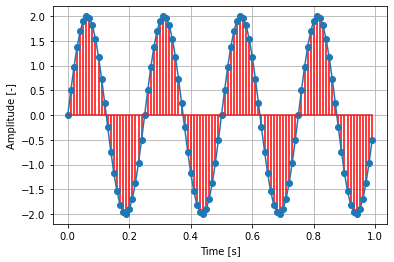

In [15]:
y = 2 * np.sin(2 * np.pi * f * t)
plt.plot(t, y)
plt.stem(t, y, 'r')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [-]')
plt.grid(True)
plt.show()

Option 2: Signal based on number of samples

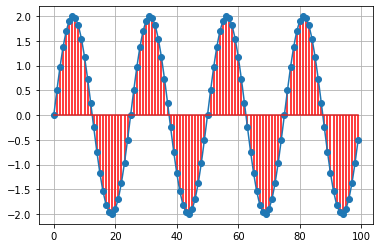

In [16]:
y = 2 * np.sin(2 * np.pi * f * x / fs)
plt.plot(x, y)
plt.stem(x, y, 'r')
plt.grid(True)
plt.show()

# Calculate Spectral Amplitudes
## 1) Generate signal

In [17]:
y = 2 * np.sin(2 * np.pi * f * t)

## 2) Fast Fourier Transform (complex output)

In [18]:
y_spectrum = fft(y)

## 3) Spectral Amplitudes - absolute value of complex numbers

In [19]:
y_magnitude_spectrum = np.abs(y_spectrum)

## 4) One-sided magnitude spectrum, including DC and fs/2 spectral components

In [20]:
y_real_magnitude_spectrum = np.abs(rfft(y))

## 5) Scaling with respect to the number of samples
Scaling the spectrum is based on division by half of the FFT's length (N/2), so the spectrum values can be
representative of the energy of each spectral component, since the signal's energy is spread equally into two parts of
spectrum, and we are analysing only one (real) part of them.

In [21]:
y_real_magnitude_spectrum /= (N / 2)

In [22]:
df = 1 / T  # spectral resolution, also defined as fs / N
freq = rfftfreq(N, dt)  # or np.arange(0, (fs / 2) + 1, df)
freq

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

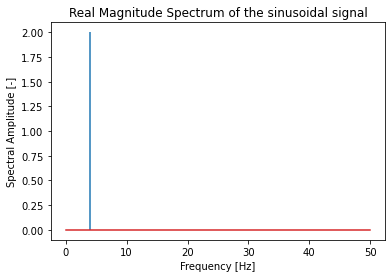

In [23]:
plt.stem(freq, y_real_magnitude_spectrum, markerfmt='none')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Spectral Amplitude [-]')
plt.title('Real Magnitude Spectrum of the sinusoidal signal')
plt.show()

# Working on my signals

In [24]:
def averaged_magnitude_spectrum(data_dict, _k=100):
    for datetime, _signal in data_dict.items():

        # Compute the one-dimensional Fast Fourier Transform for real input, including DC and fs/2 components.
        # Obtain the one-sided Magnitude Spectrum - absolute value of real numbers.
        # Scale the Spectrum with respect to the number of samples
        magnitude_spectrum = np.abs(rfft(_signal)) / (len(_signal) / 2)

        # Segment the Spectrum into k-equal chunks.
        # Magnitude_spectrum has size (N / 2) + 1, it cannot be divided equally into even k-chunks.
        # Therefore we take into account the spectrum for frequencies [0; fs/2] Hz.
        chunks = np.split(magnitude_spectrum[:-1], _k)

        # Averaged Magnitude Spectrum
        averaged_spectrum = np.array([np.mean(chunk) for chunk in chunks])

        yield datetime, averaged_spectrum

In [25]:
k = 100
mode7_spectrum = {datetime: avg_spectrum for datetime, avg_spectrum in averaged_magnitude_spectrum(all_data, k)}

In [26]:
freq_chunks = [f'{i} Hz' for i in range(0, int(k ** 2 / T), int(1 / (T / k)))]
mode7_spectrum_df = pd.DataFrame.from_dict(data=mode7_spectrum, orient='index', columns=freq_chunks)
mode7_spectrum_df.head()

,0 Hz,100 Hz,200 Hz,300 Hz,400 Hz,500 Hz,600 Hz,700 Hz,800 Hz,900 Hz,...,9000 Hz,9100 Hz,9200 Hz,9300 Hz,9400 Hz,9500 Hz,9600 Hz,9700 Hz,9800 Hz,9900 Hz
2020-10-16 10:51:26,0.001708,0.001529,0.001559,0.001527,0.001543,0.001520,0.001530,0.001612,0.001947,0.002318,...,0.000438,0.000393,0.000342,0.000302,0.000261,0.000206,0.000166,0.000122,0.000072,0.000028
2020-10-17 10:51:26,0.001636,0.001540,0.001512,0.001524,0.001549,0.001497,0.001539,0.001621,0.001957,0.002323,...,0.000432,0.000390,0.000352,0.000300,0.000258,0.000209,0.000164,0.000115,0.000071,0.000028
2020-10-18 10:51:26,0.001660,0.001561,0.001499,0.001502,0.001522,0.001529,0.001553,0.001612,0.001951,0.002254,...,0.000440,0.000401,0.000342,0.000310,0.000259,0.000214,0.000168,0.000119,0.000075,0.000031
2020-10-19 10:51:26,0.001682,0.001587,0.001542,0.001525,0.001530,0.001547,0.001542,0.001593,0.001937,0.002274,...,0.000453,0.000409,0.000372,0.000323,0.000272,0.000233,0.000182,0.000141,0.000100,0.000077
2020-10-20 10:51:26,0.001652,0.001567,0.001549,0.001554,0.001566,0.001578,0.001560,0.001601,0.001927,0.002307,...,0.000436,0.000385,0.000346,0.000297,0.000267,0.000217,0.000170,0.000118,0.000073,0.000029


In [27]:
# mode7_spectrum_df.to_csv('D:\Praca Inżynierska\csv_files\MODE7_SPECTRUM_100.csv')

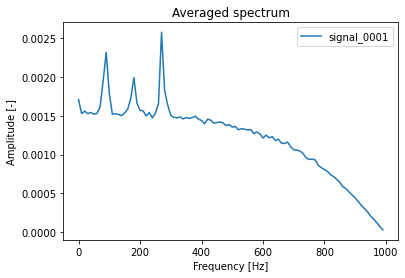

In [28]:
averaged_spectrum_0001 = mode7_spectrum_df.iloc[0].values
plt.plot(np.arange(0, 1000, 10), averaged_spectrum_0001, label='signal_0001')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [-]')
plt.title('Averaged spectrum')
plt.legend()
plt.show()

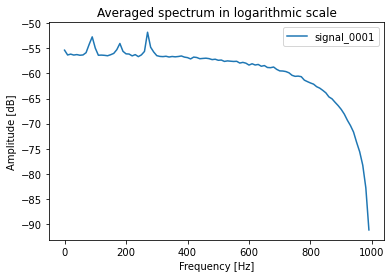

In [29]:
plt.plot(np.arange(0, 1000, 10), 20 * np.log10(averaged_spectrum_0001), label='signal_0001')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.title('Averaged spectrum in logarithmic scale')
plt.legend()
plt.show()

In [30]:
fs = 25e3
T = 10
dt = 1 / fs
t = np.arange(0, T, dt)

signal_0001 = mode7_dfT.iloc[0].values
N = len(signal_0001)

In [31]:
total_power_0001 = np.sum(np.square(signal_0001)) / N
print('Total power of signal_0001:', total_power_0001)

Total power of signal_0001: 0.15871961797008455


In [32]:
M = N / k # total number of samples divided into k-equal chunks
window = np.hamming(M)   # Hanning window
overlap = 0.5   # 50% overlap
n_overlap = int(round(M * overlap)) # overlap in samples
_f, _t, _Sxx = spectrogram(signal_0001,
                           fs=fs,
                           window=window,
                           nperseg=M, # samples per segment
                           noverlap=n_overlap, # overlapping samples
                           scaling='spectrum',
                           mode='magnitude')

# Compute the average spectrum
_avg_spectrum = np.mean(_Sxx, axis=1)


# Welch’s power spectral density estimate
Welch’s method computes an estimate of the power spectral density by dividing the data into overlapping segments,
computing a modified periodogram for each segment and averaging the periodograms.
### Power Spectral Density

In [33]:
M = N / k # length of each segment
window = np.hamming(M)
overlap = .5
n_overlap = M * overlap

In [34]:
f_den, Pxx_den = welch(signal_0001,
                         fs=fs,
                         window=window,
                         nperseg=M,
                         noverlap=n_overlap,
                         scaling='density',
                         average='mean')

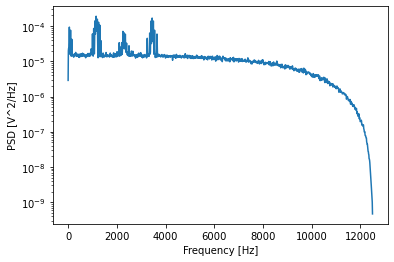

In [35]:
plt.semilogy(f_den, Pxx_den, label='signal_0001')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

### Power Spectrum

In [36]:
f_spec, Pxx_spec = welch(signal_0001,
                         fs=fs,
                         window=window,
                         nperseg=M,
                         noverlap=n_overlap,
                         scaling='spectrum',
                         average='mean')

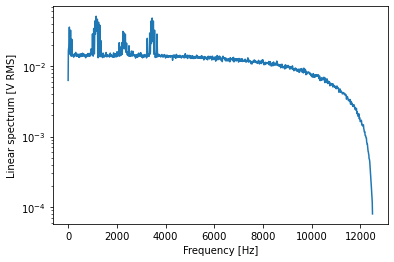

In [37]:
plt.semilogy(f_spec, np.sqrt(Pxx_spec), label='signal_0001')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

In [38]:
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################

In [157]:
# MANUAL APPROACH
spectrum_0001_m = fft(signal_0001)    # 2. FFT (complex output)
spectrum_0001_m = np.abs(spectrum_0001_m)   # 3. Spectral amplitudes - absolute value of complex numbers
spectrum_0001_m = spectrum_0001_m[:int(N / 2) + 1] # 4. One-sided spectrum, including DC and fs/2 components
spectrum_0001_m = spectrum_0001_m / (N / 2) # 5. Scaling with respect to the number of samples

f_0001_m = np.linspace(start=0, stop=int(fs / 2), num=int(N / 2) + 1, endpoint=True)

#######################################################################################################################
# FUNCTIONAL APPROACH
spectrum_0001 = rfft(signal_0001)   # 1. FFT on real input values
spectrum_0001 = np.abs(spectrum_0001)   # 2. One-sided Spectral amplitudes, including DC and fs/2 components
spectrum_0001 = spectrum_0001 / (N / 2) # 3. Scaling with respect to the number of samples

df = fs / N
f_0001 = rfftfreq(N, dt)

In [158]:
assert all(np.round(spectrum_0001_m, 8) == np.round(spectrum_0001, 8)) and all(f_0001_m == f_0001), print('Manual approach results in different values than functional.')

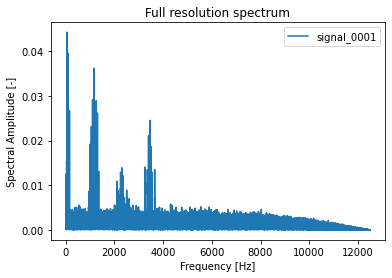

In [159]:
plt.plot(f_0001, spectrum_0001, label='signal_0001')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Spectral Amplitude [-]')
plt.title('Full resolution spectrum')
plt.legend()
plt.show()


In [41]:
signal_0999 = mode7_dfT.iloc[-1].values

In [76]:
# SPECTRUM AVERAGING: METHOD 1
def spectrum_averaging_method_1(_signal, _k):
    # 1. DIVIDE THE SIGNAL INTO K-EQUAL FRAGMENTS
    for chunk in np.split(_signal, _k):
        _N = len(chunk)
        # 2. CALCULATE THE SPECTRUM FOR EACH CHUNK
        spectrum = np.abs(rfft(chunk)) / (_N / 2)
        # 3. TAKE THE MEAN VALUE OF THE SPECTRUM
        yield np.mean(spectrum)

# SPECTRUM AVERAGING: METHOD 2
def spectrum_averaging_method_2(_signal, _k):
    _N = len(_signal)
    # 1. CALCULATE THE SPECTRUM FOR SIGNAL
    spectrum = np.abs(rfft(_signal)) / (_N / 2)
    # 2. DIVIDE THE SPECTRUM INTO K FRAGMENTS
    for chunk in np.array_split(spectrum, _k):
        # 3. TAKE THE MEAN VALUE OF THE SPECTRUM FRAGMENT
        yield np.mean(chunk)

In [106]:
start_1 = time.time()
spectrum_0999_1 = np.array([avg_spectrum_1 for avg_spectrum_1 in spectrum_averaging_method_1(signal_0999, k)])
end_1 = time.time()
exec_time_1 = end_1 - start_1
print(f'Execution time of Method 1: {exec_time_1}s')


start_2 = time.time()
spectrum_0999_2 = np.array([avg_spectrum_2 for avg_spectrum_2 in spectrum_averaging_method_2(signal_0999, k)])
end_2 = time.time()
exec_time_2 = end_2 - start_2
print(f'Execution time of Method 2: {exec_time_2}s')


freq_0999 = np.arange(start=0, stop=k * T, step=1 / (T / k))

Execution time of Method 1: 0.006987810134887695s
Execution time of Method 2: 0.009966611862182617s


In [160]:
time_delta = abs(exec_time_2 - exec_time_1)
if exec_time_2 < exec_time_1:
    print(f'Method 2 is faster by {np.round(time_delta * 100 / exec_time_1, 2)} %')
else:
    print(f'Method 1 is faster by {np.round(time_delta * 100 / exec_time_2, 2)} %')

Method 1 is faster by 29.89 %


#### Time of Method 1

In [109]:
cProfile.run('np.array([avg_spectrum_1 for avg_spectrum_1 in spectrum_averaging_method_1(signal_0999, k)])')

         3426 function calls (3324 primitive calls) in 0.008 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(array_split)
      100    0.000    0.000    0.002    0.000 <__array_function__ internals>:2(mean)
      100    0.000    0.000    0.004    0.000 <__array_function__ internals>:2(rfft)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(split)
      101    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(swapaxes)
      101    0.002    0.000    0.008    0.000 <ipython-input-76-edf67472957a>:2(spectrum_averaging_method_1)
        1    0.000    0.000    0.008    0.008 <string>:1(<listcomp>)
        1    0.000    0.000    0.008    0.008 <string>:1(<module>)
      100    0.000    0.000    0.000    0.000 _asarray.py:14(asarray)
      100    0.000    0.000    0.000    0.000 _asarray.py:86(asanyarray)
   

#### Time of Method 2

In [110]:
cProfile.run('np.array([avg_spectrum_2 for avg_spectrum_2 in spectrum_averaging_method_2(signal_0999, k)])')

         2431 function calls (2330 primitive calls) in 0.011 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(array_split)
      100    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(mean)
        1    0.000    0.000    0.008    0.008 <__array_function__ internals>:2(rfft)
      101    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(swapaxes)
      101    0.001    0.000    0.011    0.000 <ipython-input-76-edf67472957a>:12(spectrum_averaging_method_2)
        1    0.000    0.000    0.011    0.011 <string>:1(<listcomp>)
        1    0.000    0.000    0.011    0.011 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _asarray.py:14(asarray)
      100    0.000    0.000    0.000    0.000 _asarray.py:86(asanyarray)
      100    0.000    0.000    0.001    0.000 _methods.py:143(_mean)
      100    0.000 

### Conclusion:
Method 1 is a proper method for Spectrum Averaging. Moreover it is faster by ~30%.

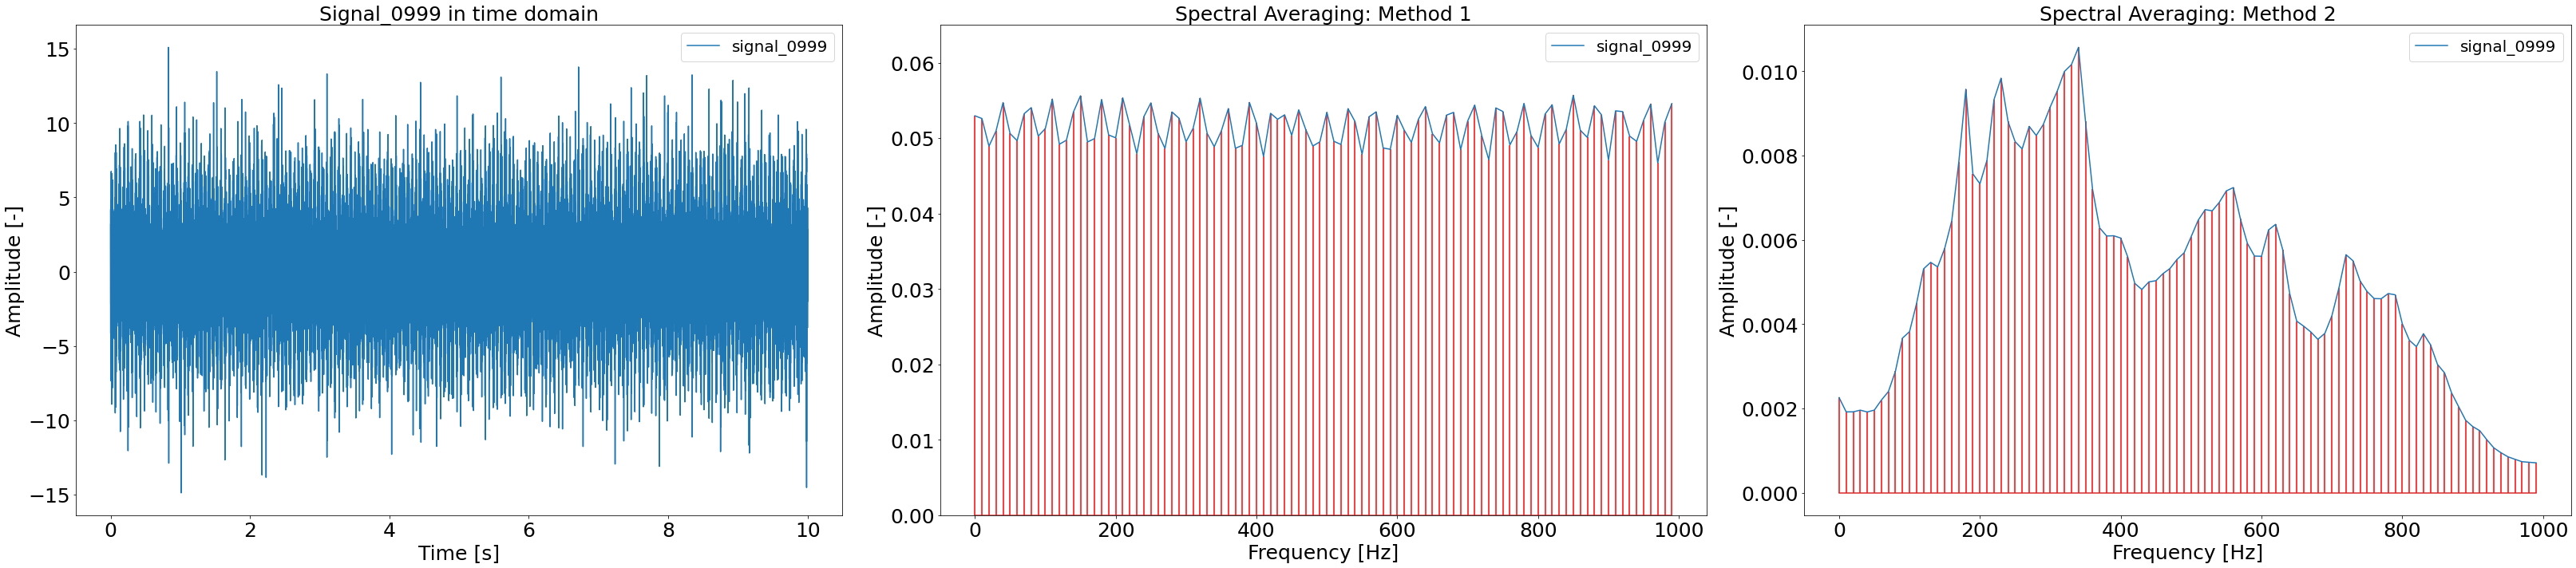

In [161]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(45, 10))

ax[0].plot(t, signal_0999, label='signal_0999')
ax[0].set_xlabel('Time [s]', fontsize=25)
ax[0].set_ylabel('Amplitude [-]', fontsize=25)
ax[0].set_title('Signal_0999 in time domain', size=25)
ax[0].tick_params(axis='both', which='major', labelsize=25)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax[0].legend(fontsize=20)

ax[1].plot(freq_0999, spectrum_0999_1, label='signal_0999')
ax[1].stem(freq_0999, spectrum_0999_1, 'r', markerfmt='none')
ax[1].set_xlabel('Frequency [Hz]', fontsize=25), ax[1].set_ylabel('Amplitude [-]', fontsize=25)
ax[1].set_title('Spectral Averaging: Method 1', size=25)
ax[1].tick_params(axis='both', which='major', labelsize=25)
ax[1].tick_params(axis='both', which='minor', labelsize=18)
ax[1].set_ylim((0, 0.065))
ax[1].legend(fontsize=20, loc='upper right')

ax[2].plot(freq_0999, spectrum_0999_2, label='signal_0999')
ax[2].stem(freq_0999, spectrum_0999_2, 'r', markerfmt='none')
ax[2].set_xlabel('Frequency [Hz]', fontsize=25), ax[2].set_ylabel('Amplitude [-]', fontsize=25)
ax[2].set_title('Spectral Averaging: Method 2', size=25)
ax[2].tick_params(axis='both', which='major', labelsize=25)
ax[2].tick_params(axis='both', which='minor', labelsize=15)
ax[2].legend(fontsize=20)

plt.tight_layout()
plt.savefig('signal_0999.jpg', bbox_inches='tight')
plt.show()

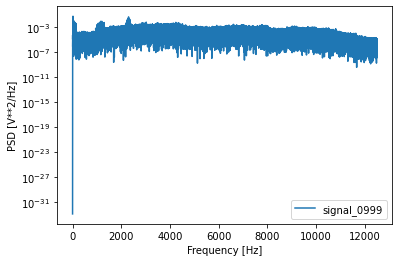

In [165]:
fr999, Pxx_den_0999 = periodogram(signal_0999, fs, scaling='density')
plt.semilogy(fr999, Pxx_den_0999, label='signal_0999')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

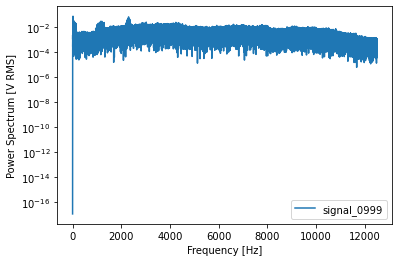

In [164]:
fr999, Pxx_spec_0999 = periodogram(signal_0999, fs, scaling='spectrum')
plt.semilogy(fr999, np.sqrt(Pxx_spec_0999), label='signal_0999')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectrum [V RMS]')
plt.legend()
plt.show()

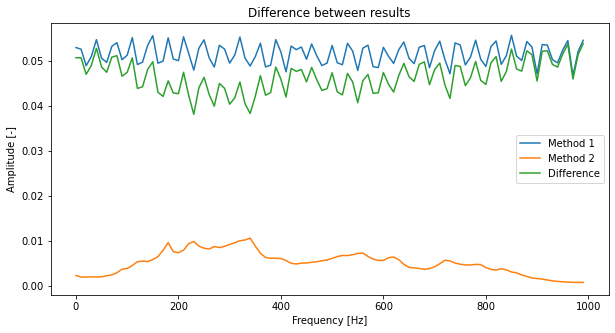

In [166]:
plt.figure(figsize=(10, 5))
plt.plot(freq_0999, spectrum_0999_1, label='Method 1')
plt.plot(freq_0999, spectrum_0999_2, label='Method 2')
plt.plot(freq_0999, spectrum_0999_1 - spectrum_0999_2, label='Difference')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Amplitude [-]')
plt.title('Difference between results')
plt.legend()
plt.show()

In [167]:
N_0999 = len(signal_0999)
overlap_0999 = 0.5
k_exp = np.round(np.log10(k)).astype(int)
nperseg_0999 = int(k / overlap_0999) - 2 ** (k_exp - 1)    # in order to obtain k-average values
window_0999 = np.hamming(nperseg_0999)
noverlap_0999 = int(overlap_0999 * nperseg_0999)

### Power Spectrum Density

In [168]:
f_den_0999, Pxx_den_0999 = welch(signal_0999,
                                 fs=fs,
                                 nperseg=nperseg_0999,
                                 noverlap=noverlap_0999,
                                 scaling='density',
                                 average='mean')

### Power Spectrum

In [169]:
f_spec_0999, Pxx_spec_0999 = welch(signal_0999,
                                 fs=fs,
                                 nperseg=nperseg_0999,
                                 noverlap=noverlap_0999,
                                 scaling='spectrum',
                                 average='mean')

In [170]:
assert Pxx_den_0999.shape[0] == Pxx_spec_0999.shape[0] == 100, f'The Averaged Spectrum does not contain {k} values!'

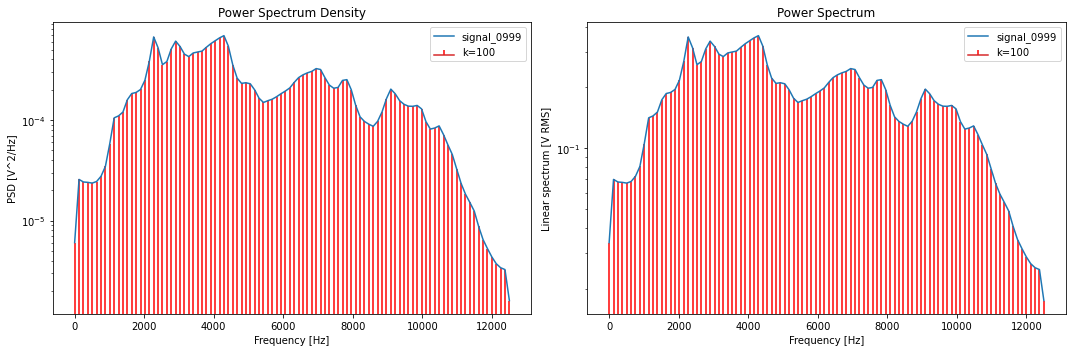

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].semilogy(f_den_0999, Pxx_den_0999, label='signal_0999')
ax[0].stem(f_den_0999, Pxx_den_0999, 'r', label=f'k={k}', markerfmt='none')
ax[0].set_title('Power Spectrum Density')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('PSD [V^2/Hz]')
ax[0].legend(loc='upper right')

ax[1].semilogy(f_spec_0999, np.sqrt(Pxx_spec_0999), label='signal_0999')
ax[1].stem(f_spec_0999, np.sqrt(Pxx_spec_0999), 'r', label=f'k={k}', markerfmt='none')
ax[1].set_title('Power Spectrum')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Linear spectrum [V RMS]')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.savefig('welch.jpg', bbox_inches='tight')
plt.show()

In [176]:
def moving_spectrum_average(spectrum, window_size=2048, overlap=0.5):
    N = len(spectrum)
    noverlap = int(overlap * window_size)
    return [np.mean(spectrum[i:i + window_size]) for i in range(0, (N - window_size) + 1, noverlap)]

In [177]:
spectrum_0999 = np.abs(rfft(signal_0999)) / (N / 2)
f_0999 = rfftfreq(N, dt)

In [178]:
averaged_spectrum_0999 = moving_spectrum_average(spectrum=spectrum_0999, window_size=4096, overlap=0.5)
k_avg = len(averaged_spectrum_0999)
averaged_f_0999 = np.arange(0, 1 / (T / k_avg) * k_avg, 1 / (T / k_avg))
print(averaged_f_0999.shape)

(60,)


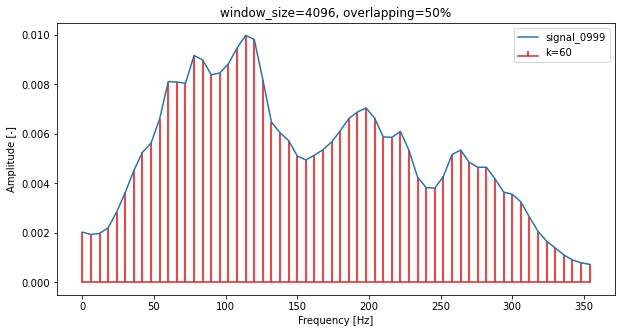

In [179]:
plt.figure(figsize=(10, 5))
plt.plot(averaged_f_0999, averaged_spectrum_0999, label='signal_0999')
plt.stem(averaged_f_0999, averaged_spectrum_0999, 'r', markerfmt='none', label=f'k={k_avg}')
plt.title('window_size=4096, overlapping=50%')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()